# Exercise 2.2 - Random Matrix theory

In [17]:
from pathlib import Path

import numpy as np
import networkx as nx
import scipy.sparse
import matplotlib.pyplot as plt
import tqdm.contrib.concurrent

import disordered_sys.generate
import disordered_sys.methods

In [2]:
epsilon = 1e-3
c = 3
n = 2**6
lam = 0
figure_dir = Path.cwd() / ".." / "report" / "figures"

m, g = disordered_sys.generate.generate_m(c, n, return_g=True)

### Implement cavity equation

In [3]:
def get_neighbors(g, k, j=-1):
    neighbors_set = set(g.neighbors(k)) - {j}
    return np.array(list(neighbors_set))

def cavity_equation(m, g, cav_precs, lam, k, j=-1):
    n_idxs = get_neighbors(g, k, j)
    n_weights = m[k, n_idxs]**2
    prec_weights = cav_precs[k, n_idxs].todense()

    return epsilon + 1j * lam + np.sum(n_weights / prec_weights)

### Initialize Marginal Cavity Precisions

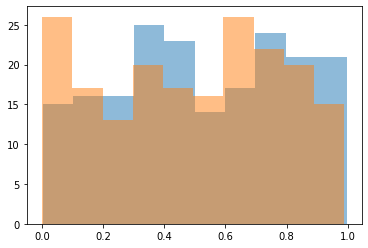

In [4]:
cavity_init = np.random.uniform(size=len(g.edges) * 2) + 1j * np.random.uniform(size=len(g.edges) * 2)
plt.hist(cavity_init.real, alpha=.5)
plt.hist(cavity_init.imag, alpha=.5)
plt.savefig(figure_dir / "ex2_cavity_init_hist.pdf")

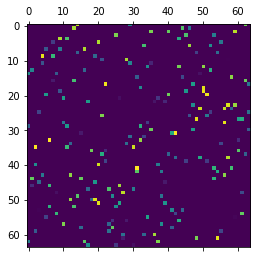

In [5]:
adj_mat = nx.to_scipy_sparse_array(g, nodelist=sorted(list(g.nodes())))
cavity_init = adj_mat[adj_mat.nonzero()] * cavity_init
cavity_precs = scipy.sparse.coo_matrix((cavity_init, adj_mat.nonzero()))
cavity_precs = cavity_precs.tocsr(copy=False)
plt.matshow(cavity_precs.todense().real)
plt.savefig(figure_dir / "ex2_cavity_init_mat.pdf")

In [6]:
def init_cavity_precs(g):
    cavity_init = np.random.uniform(size=len(g.edges) * 2) + 1j * np.random.uniform(size=len(g.edges) * 2)
    adj_mat = nx.to_scipy_sparse_array(g, nodelist=sorted(list(g.nodes())))
    cavity_init = adj_mat[adj_mat.nonzero()] * cavity_init
    cavity_precs = scipy.sparse.coo_matrix((cavity_init, adj_mat.nonzero()))
    cavity_precs = cavity_precs.tocsr(copy=False)
    return cavity_precs

### Run the Cavity method to obtain Marginal Cavity Precisions

In [7]:
tol = 1e-10
delta = np.inf

while delta > tol:
    reference = cavity_precs.copy()
    for k, j in g.to_directed().edges:
        cavity_precs[j, k] = cavity_equation(m, g, cavity_precs, lam, k, j)
    delta = np.max(np.abs(cavity_precs - reference))
    print(f"{delta=:.4e}", end="\r")

### Show the distributions of Marginal Cavity Precisions

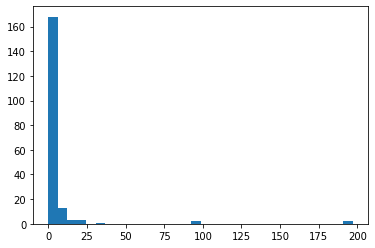

In [8]:
plt.hist(np.array(cavity_precs[cavity_precs.nonzero()]).flatten().real, bins=n // 2)
plt.savefig(figure_dir / "ex2_cavity_precs_real.pdf")

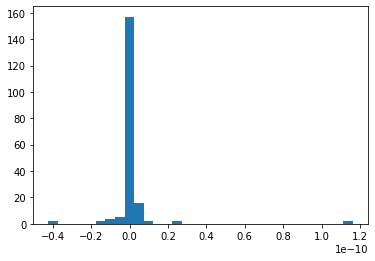

In [9]:
plt.hist(np.array(cavity_precs[cavity_precs.nonzero()]).flatten().imag, bins=n // 2)
plt.savefig(figure_dir / "ex2_cavity_precs_imag.pdf")

### Calculate the Marginal Precisions

In [10]:
marginals = np.sum(cavity_precs, axis=1)  # type: ignore
print(marginals)

[[  1.91164796+2.50159751e-12j]
 [  3.13008161-1.35824208e-12j]
 [  0.44215902-4.25830860e-13j]
 [  8.0374374 -1.01438881e-12j]
 [213.98335338+1.15844658e-10j]
 [  0.33404266+7.47205576e-14j]
 [  5.23844967-1.06632066e-12j]
 [102.22845004-4.34609731e-11j]
 [  0.44980365-1.56875251e-13j]
 [  3.65351127+2.85428576e-12j]
 [  7.76093572-7.38283815e-12j]
 [  3.5260904 +2.96677783e-12j]
 [ 23.78830641+4.09851834e-12j]
 [  4.00019043+3.43916907e-12j]
 [ 10.20599236+7.42369602e-13j]
 [  1.94672712-1.07455600e-12j]
 [  0.96135835-3.89286549e-13j]
 [  0.55774889-3.33169679e-13j]
 [  7.48326457+5.35441996e-12j]
 [197.69294607+1.11390024e-10j]
 [ 98.1895416 -4.29787608e-11j]
 [  9.14062376-3.38077467e-13j]
 [  5.77082506+2.87413144e-12j]
 [  3.76175425-4.43333962e-13j]
 [  1.98996011-1.27522404e-12j]
 [  2.87560732-2.15922699e-12j]
 [  7.98764891+4.03272962e-12j]
 [  0.85182884+5.41679173e-13j]
 [  4.30308091-7.57796044e-13j]
 [ 37.8090844 +2.49737905e-11j]
 [  0.62948553+7.86387773e-14j]
 [  4.82

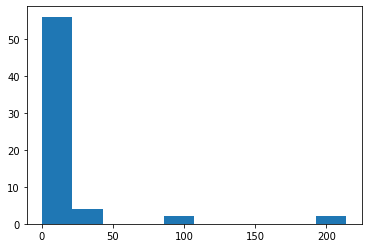

In [11]:
plt.hist(marginals.real)
plt.savefig(figure_dir / "ex2_marginal_precs_real.pdf")

### Calculate the spectral density

In [12]:
G_ii = 1j / marginals
rho_lambda = G_ii.imag.mean() / np.pi
print(rho_lambda)

0.1788593179889133


### Sweep over different $\lambda$

In [18]:
lambdas = np.linspace(-3, 3, num=100)

def spectral_density(lam):
    cavity_precs = init_cavity_precs(g)

    delta = np.inf
    while delta > tol:
        reference = cavity_precs.copy()
        for k, j in g.to_directed().edges:
            cavity_precs[j, k] = cavity_equation(m, g, cavity_precs, lam, k, j)
        delta = np.max(np.abs(cavity_precs - reference))

    marginals = np.sum(cavity_precs, axis=1)  # type: ignore
    G_ii = 1j / marginals
    rho_lambda = G_ii.imag.mean() / np.pi
    return rho_lambda

tqdm.contrib.concurrent.process_map(spectral_density, lambdas)

  0%|          | 0/100 [00:00<?, ?it/s]

Process ForkProcess-2:
Process ForkProcess-8:
Process ForkProcess-7:
Process ForkProcess-6:

KeyboardInterrupt

Process ForkProcess-3:
Traceback (most recent call last):


2022-10-11T17:00:07.623140+0200 - Timed out waiting for syncing to complete.


Process ForkProcess-5:
Process ForkProcess-1:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/proc

TypeError: float() argument must be a string or a real number, not 'function'

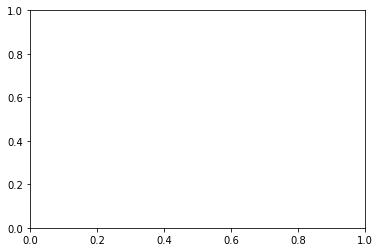

In [20]:
plt.plot(spectral_density)